In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/dacon_mnist/')
from google.colab import output
!pip install -r requirements.txt
output.clear()

In [3]:
import os
import cv2
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import util
import easydict
import albumentations
import albumentations.pytorch
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Device : {}'.format(device))

args = easydict.EasyDict({
    "device": device,
    "mnist_fn": './data/old_data/train.csv',
    "model": 'efficientnet-b7',
    "resume": None,

    "lr": 1e-4,
    "batch_size": 4,
    "epochs": 2000,
    "patient": 8,

    "dataset_ratio": 0.75,
})

util.seed_everything(777)
assert os.path.isfile(args.mnist_fn), 'wrong path'

Device : cuda:0


# 새 섹션

In [5]:
class DatasetOldMNIST(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):        
        # self.images = df.drop(['id', 'digit', 'letter'], axis=1).values
        # self.images = self.images.reshape(-1, 28, 28)
        # self.labels = pd.get_dummies(df['letter']).values

        self.images = images
        self.labels = labels
        self.transforms=transforms

        temp = np.zeros(shape=(self.images.shape[0], 256, 256))

        for idx in range(self.images.shape[0]):
            image = self.images[idx]

            # scale = np.random.rand() + 0.5
            # dsize = (int(image.shape[0] * scale), int(image.shape[1] * scale))
            # image = cv2.resize(
            #     image.astype('float32'),
            #     dsize=dsize, 
            #     interpolation=cv2.INTER_LINEAR,
            # )

            # x = np.random.randint(0, 256 - dsize[1])
            # y = np.random.randint(0, 256 - dsize[0])

            # temp[idx][y:y+dsize[0], x:x+dsize[1]] = image
            temp[idx] = cv2.resize(
                    image.astype('float32'),
                    dsize=(256, 256), 
                    interpolation=cv2.INTER_LINEAR,
                )
            
        temp = temp.reshape([-1, 256, 256, 1]) 
        self.images = temp

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):        
        image = self.images[idx]
        label = self.labels[idx]

        if self.transforms:            
            image = self.transforms(image=image)['image'] / 255.0

        return image, label

In [6]:
train_transforms = albumentations.Compose([
    albumentations.RandomRotate90(),
    albumentations.VerticalFlip(),     
    albumentations.CLAHE(),
    albumentations.ShiftScaleRotate(),
    albumentations.OneOf([
        albumentations.Perspective(p=1),
        albumentations.ElasticTransform(p=1),
    ], p=1),
    albumentations.augmentations.Cutout(num_holes=16, max_h_size=15, max_w_size=15, fill_value=0),
    albumentations.pytorch.ToTensorV2(),
])

valid_transforms = albumentations.Compose([
    albumentations.pytorch.transforms.ToTensor()
])

In [7]:
df = pd.read_csv(args.mnist_fn)[:400]

images = df.drop(['id', 'digit', 'letter'], axis=1).values
images = images.reshape(-1, 28, 28)

encoder = LabelEncoder()
encoder.fit(df['letter'])

labels = encoder.transform(df['letter'])

In [8]:
train_set_nb = int(len(df) * args.dataset_ratio)

train_set = DatasetOldMNIST(
    images=images[:train_set_nb],
    labels=labels[:train_set_nb],
    transforms=train_transforms,
)

valid_set = DatasetOldMNIST(
    images=images[train_set_nb:],
    labels=labels[train_set_nb:],
    transforms=valid_transforms,
)

train_data_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size = args.batch_size,
        shuffle = True,
    )

valid_data_loader = torch.utils.data.DataLoader(
        valid_set,
        batch_size = args.batch_size,
        shuffle = False,
    )


model = model = EfficientNet.from_pretrained(args.model, in_channels=1, num_classes=26, dropout_rate=0.3)
print('[info msg] {} model is created\n'.format(args.model))
print('=' * 50)

optimizer = torch.optim.Adam(model.parameters(), args.lr)
criterion = torch.nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=2,
    factor=0.5,
    verbose=True
    )

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7
[info msg] efficientnet-b7 model is created



[info msg] training start !!

Epoch 1/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 14.21it/s, loss - 3.249981]
MODEL SAVED!
Epoch 2/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.89it/s, loss - 3.233411]
MODEL SAVED!
Epoch 3/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.95it/s, loss - 3.214738]
MODEL SAVED!
Epoch 4/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.86it/s, loss - 3.027979]
MODEL SAVED!
Epoch 5/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.79it/s, loss - 2.657357]
MODEL SAVED!
Epoch 6/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.78it/s, loss - 2.404235]
MODEL SAVED!
Epoch 7/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.67it/s, loss - 2.160442]
MODEL SAVED!
Epoch 8/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.75it/s, loss - 1.815291]
MODEL SAVED!
Epoch 9/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.70it/s, loss - 1.828688]
Epoch 10/2000
Valid: 100%|██████████| 25/25 [00:01<00:00, 13.68it/s, loss - 1.704749]
MODEL SAVED!
Ep

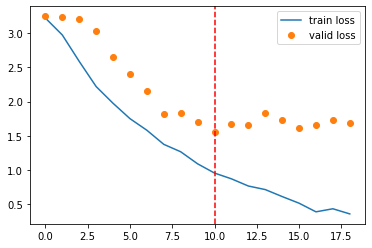

In [9]:
train_error = []
valid_error = []

best_loss = float("inf")
best_loss_pos = None

patient = 0
patient_limit = args.patient

date_time = datetime.now().strftime("%m%d%H%M")
SAVE_DIR = os.path.join('./save', date_time + '_char')

if(args.resume):
    model.load_state_dict(torch.load(args.resume))
    print('[info msg] pre-trained weight is loaded !!\n')        
    print(args.resume)
    print('=' * 50)

print('[info msg] training start !!\n') 

startTime = datetime.now()

if args.device is 'cuda' and torch.cuda.device_count() > 1 :
    model = torch.nn.DataParallel(model)

model.to(device)

for epoch in range(args.epochs):        
    print('Epoch {}/{}'.format(epoch+1, args.epochs))
    train_loss = util.train(
        train_loader=train_data_loader,
        model=model,
        loss_func=criterion,
        device=args.device,
        optimizer=optimizer,
        )
    train_error.append(train_loss)

    valid_loss = util.validate(
        valid_loader=valid_data_loader,
        model=model,
        loss_func=criterion,
        device=args.device,
        scheduler=scheduler,
        )
    valid_error.append(valid_loss)        

    is_best = best_loss > valid_loss

    if is_best:
        patient = 0
        best_loss = valid_loss
        
        Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'model_best.pth.tar'))
        print('MODEL SAVED!')
        
    else:
        patient += 1
        if patient > patient_limit - 1:
            print('=======' * 10)
            print("[Info message] Early stopper is activated")
            break

elapsed_time = datetime.now() - startTime

train_error = np.array(train_error)
valid_error = np.array(valid_error)
best_loss_pos = np.argmin(valid_error)

print('=' * 50)
print('[info msg] training is done\n')
print("Time taken: {}".format(elapsed_time))
print("best loss is {} at epoch : {}".format(best_loss, best_loss_pos))

print('=' * 50)
print('[info msg] {} model weight and log is save to {}\n'.format(args.model, SAVE_DIR))

with open(os.path.join(SAVE_DIR, 'log.txt'), 'w') as f:
    for key, value in vars(args).items():
        f.write('{} : {}\n'.format(key, value))            

    f.write('\n')
    f.write('total ecpochs : {}\n'.format(str(train_error.shape[0])))
    f.write('time taken : {}\n'.format(str(elapsed_time)))
    f.write('best_train_loss at {} epoch : {}\n'.format(np.argmin(train_error), np.min(train_error)))
    f.write('best_valid_loss at {} epoch : {}\n'.format(np.argmin(valid_error), np.min(valid_error)))

plt.plot(train_error, label='train loss')
plt.plot(valid_error, 'o', label='valid loss')
plt.axvline(x=best_loss_pos, color='r', linestyle='--', linewidth=1.5)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, 'history.png'))
plt.show()

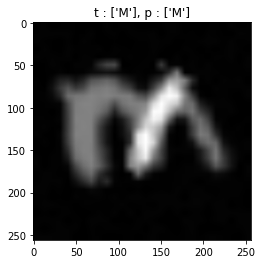

In [43]:
idx = np.random.randint(len(valid_data_loader))

image_t, label_t = valid_set[idx]

model.eval()
pred_t = model(torch.unsqueeze(image_t, axis=0).float().to(args.device))
pred = np.argmax(pred_t.detach().to('cpu').numpy())

plt.title(f't : {encoder.inverse_transform([label_t])}, p : {encoder.inverse_transform([pred])}')
plt.imshow(transforms.ToPILImage()(image_t), 'gray')
plt.show()

# 새 섹션